![An Insight Into Cyber Bullying](https://raw.githubusercontent.com/Dutta-SD/Images_Unsplash/master/cyber_bullying_images/cYBER_bULLYING_bANNER.png)


# The Problem of Cyber Bullying
> With the rise of social media and degraded morality, cyber bullying has become a terrible menace of modern times. Social Media grants us anonymity, 
which leads some distorted minds to think they can get away with anything. So they pick out on people, befriend them and then shower them with hate.
    
> The problem may seem to some to be another sort of high school bully. But cyber bullying is done on social media where information is permanant. 
So this becomes a lifelong trauma for victims. Depression and Suicide are common after effects of this nemesis, but not much has been done to curb this menace.

In this notebook, Let us analyse the data we have and try to come up with a classifier which might help us to deter cyberbullying to some extent.

### WARNING : Strong Language Ahead!

# Importing the Data

In [30]:
# Imports for common tasks, models imported later
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import gensim
from sklearn.metrics import fbeta_score
from imblearn.combine import SMOTETomek
import missingno as msn
from IPython.display import Image
from transformers import BertTokenizer, BertModel

%matplotlib inline

In [31]:
#df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv", nrows=1000)
df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv")
# See first few rows
df.head()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN


# Exploration of the dataset

## 1. BarPlot of missing values

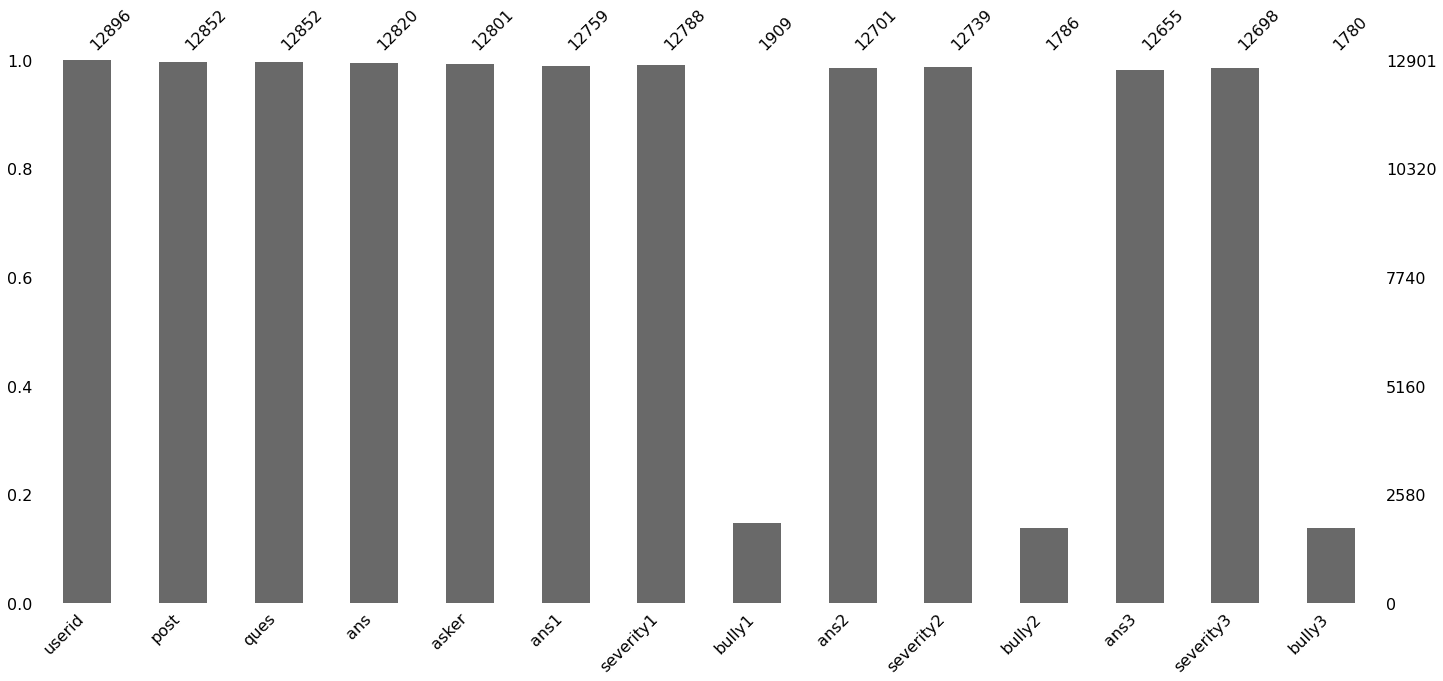

In [32]:
# missing values visualisation
msn.bar(df);

## Inference
Lots of Bully posts are missing values. Few rows are missing in 'ques', 'ans' columns. This might suggest that missing completely at random data. 

## 2. Distribution of userid column

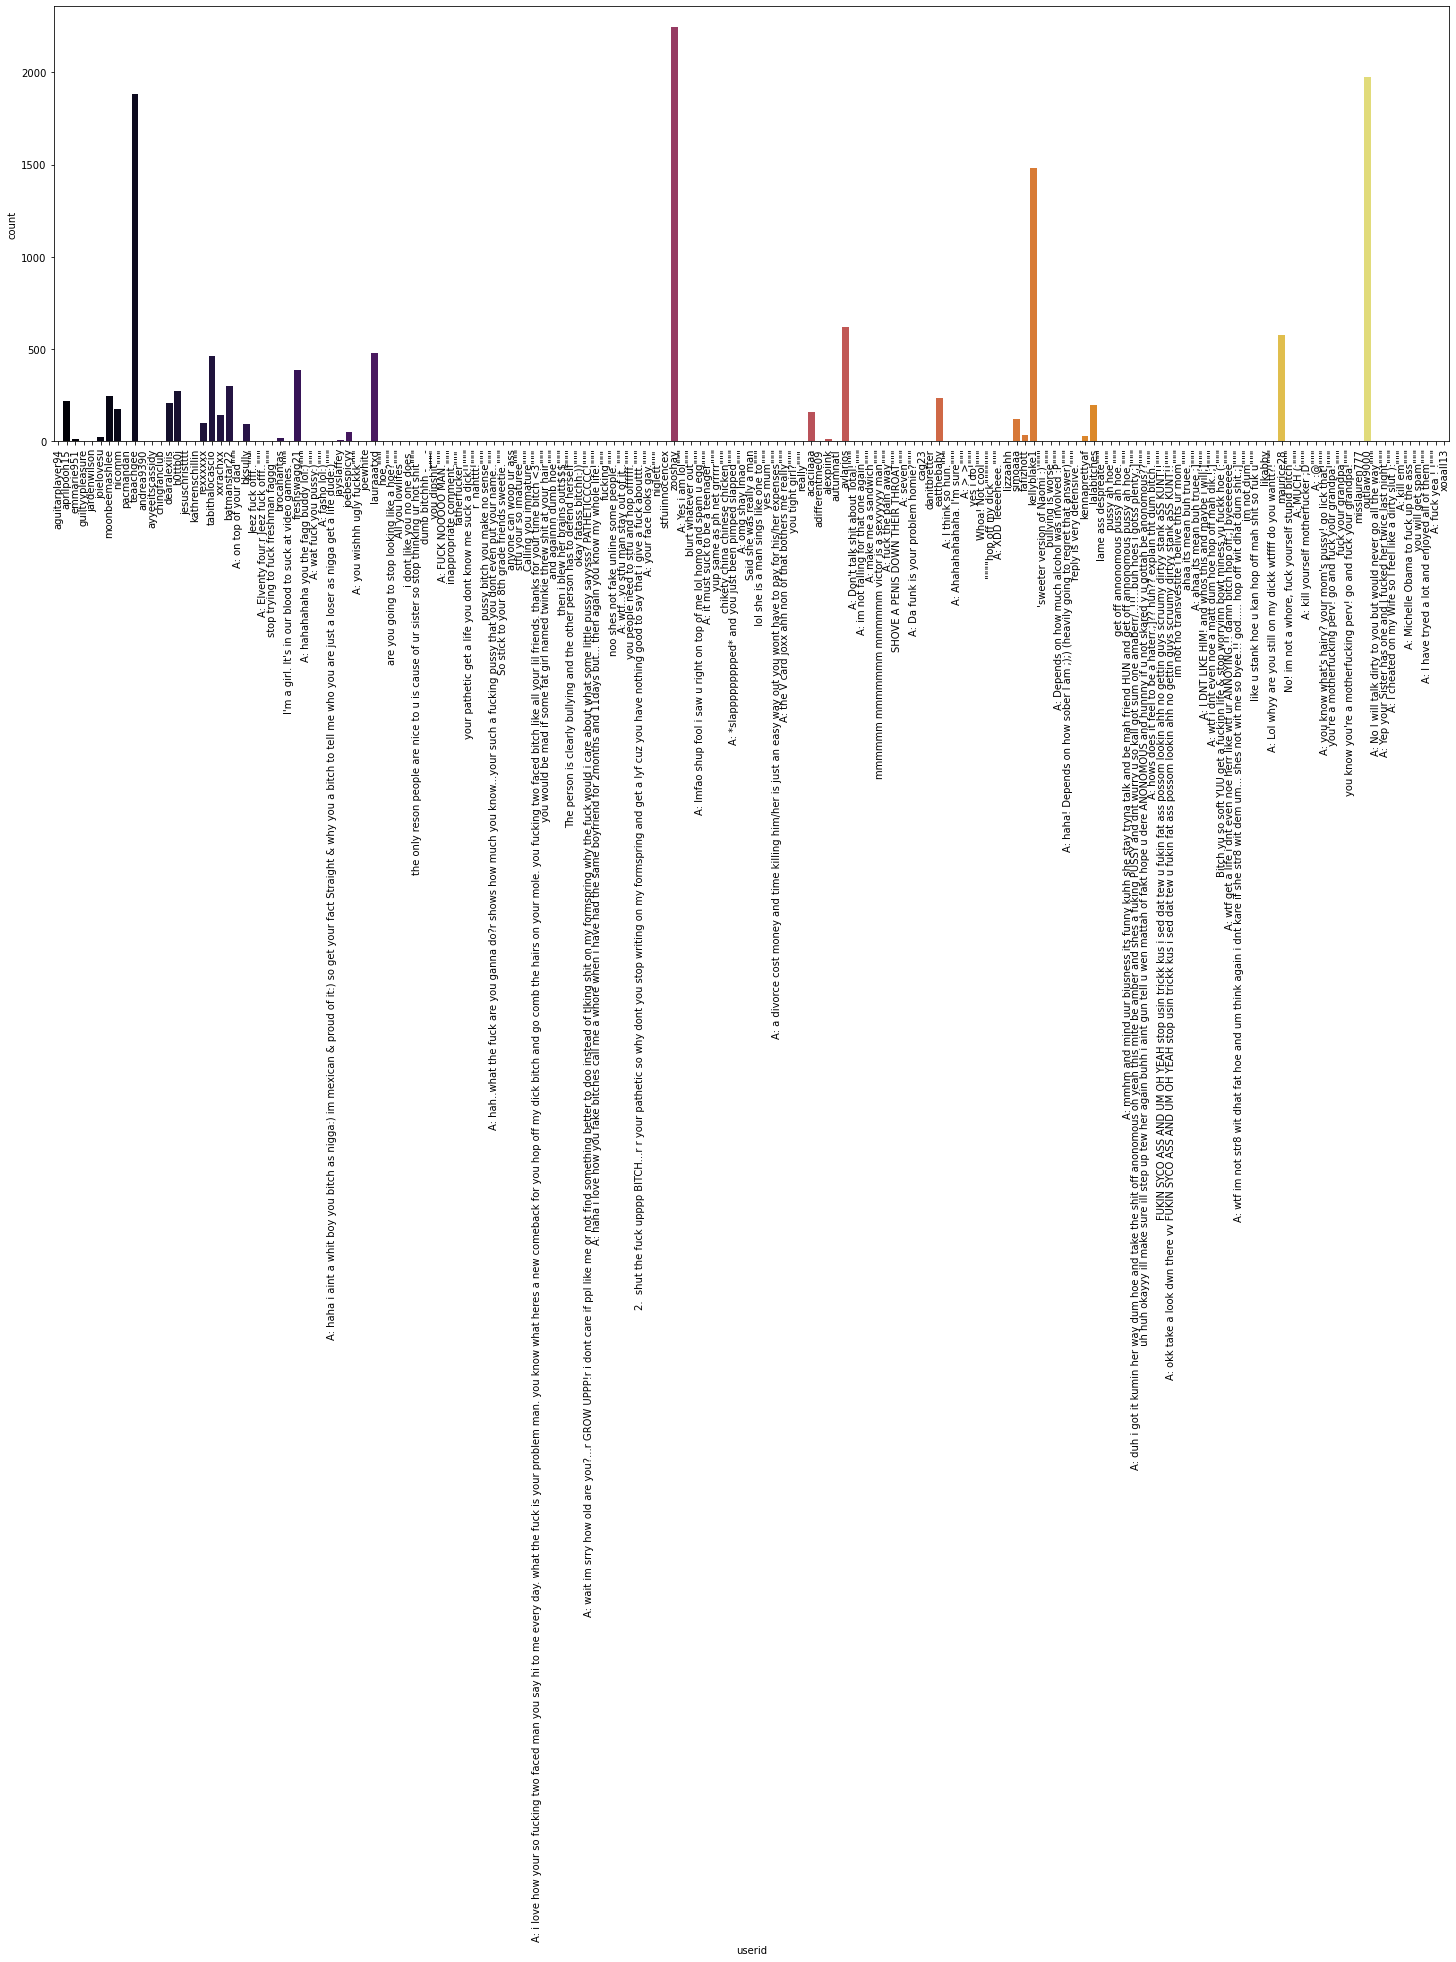

In [33]:
plt.figure(figsize = (25, 8))
sns.countplot(df['userid'], palette='inferno')
plt.xticks(rotation = 90);

## Inference
Some rows are corrupted whereby the answers have been filled wrong. We need to remove these(maybe?) or deal with them in some way(based on their counts).

## Visualisation of asker

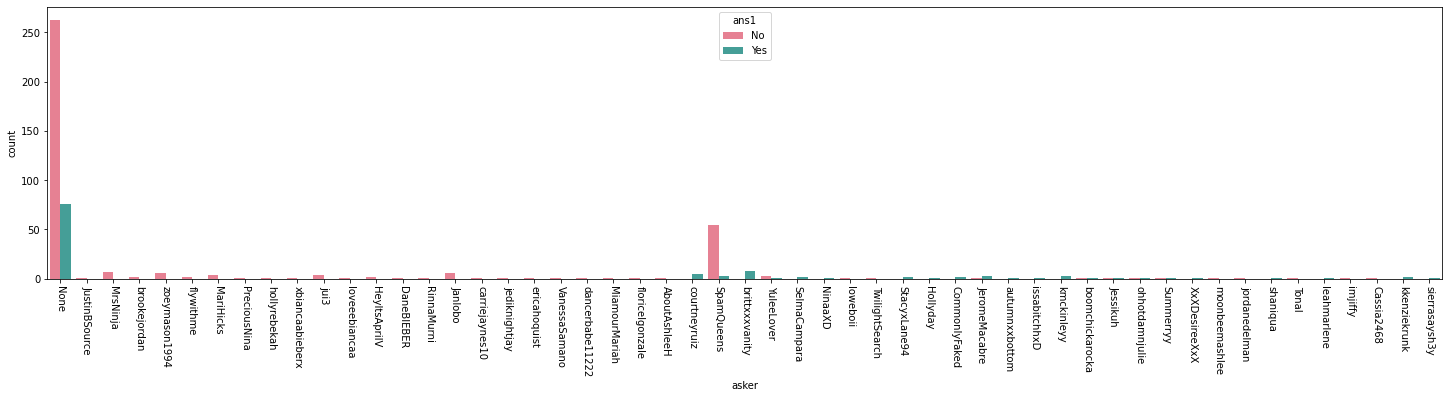

In [34]:
plt.figure(figsize = (25, 5))
sns.countplot(df['asker'][:500],
             palette = 'husl',
             hue = df['ans1'][:500]) # For convenience, see only first few rows
plt.xticks(rotation = -90);

## Inference
Lots of unique values. Might not be suitable for predicting purposes.

## WordClouds
Let us see the vocabulary of the bullies

In [35]:
## Generate Word Clouds
#bullyDF = df[df['ans1'] == 'Yes']
#Words = [str(i) for i in bullyDF['ques']]
#WordsString = (" ".join(Words)).lower()
#WordsString = re.sub(r'[^\w\s]', '', WordsString)

# mask
#img_url = 'https://raw.githubusercontent.com/Dutta-SD/Images_Unsplash/master/cyber_bullying_images/I%20AM%20FINE.png'
#from urllib.request import urlopen
#from PIL import Image
## make mask
#img = urlopen(img_url)
#mask = np.array(Image.open(img))

# WORDCLOUD
#from wordcloud import WordCloud
#wc = WordCloud(width = 1200, height = 1200,
#              background_color = 'white',
#              mask = mask,
#              contour_width=3).generate(WordsString)
#plt.figure(figsize = (12, 12), facecolor = None) 
#plt.imshow(wc); 
#plt.axis("off");

# Stop saying it's okay when it is not!

# Insights about the data set
* userid - userid of a person giving the answer to a post
* post - The post and it's reply. Separated by Q: and A.
* ques and ans - The question and answer. The same information is available in post, so we drop post
* asker - id of the person asking the question.
* ans #, severity #, bully # - answer by mechanical turk, severity score assigned, bully word/phrase

In [36]:
# Posts with actual cyberbullying content
df[df['ans1'] == 'Yes'].head()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
38,aprilpooh15,Q: Fuck Justin bieber. He&#039;s a fucking fag...,Fuck Justin bieber. He&#039;s a fucking fag,UM excuse yuh? HE IS NOT!! Ur a fuckin idiot!...,None,Yes,1,Ur a fuckin idiot!,Yes,5,Ur a fuckin idiot,Yes,5,Ur a fuckin idiot
56,aprilpooh15,Q: Hello bitch! How&#039;s ur day going? Good ...,Hello bitch! How&#039;s ur day going? Good I h...,Ohh heyy bitchh!!! its goin good..:D thx 4 askin,None,Yes,1,Hello bitch!,No,0,NaN,No,0,NaN
62,aprilpooh15,Q: Hey. Why you such a bitch?<br>A: Why thank ...,Hey. Why you such a bitch?,Why thank yuh!,None,Yes,3,"""""""""""""""why you such a bitch?""""""""""""""",Yes,5,"""""""""""""""Bitch""""""""""""""",Yes,9,Why you such a bitch?
68,aprilpooh15,Q: how old are u ? And how do you know michael...,how old are u ? And how do you know michael?,Who the hell are yuh!!! And who tha fuck is m...,None,Yes,10,Who the hell are yuh!!! And who tha fuck is mi...,Yes,2,Who the hell are yuh!!! And who tha fuck is mi...,No,None,None
114,aprilpooh15,Q: love youu sexy thang(;<br>A: Mwahaha!! Than...,love youu sexy thang(;,Mwahaha!! Thank yuh meh sexy bitch!! who is t...,None,Yes,1,Sexy bitch,No,0,NaN,No,0,NaN


In [37]:
df.drop(['post', 'asker'], axis = 1, inplace = True)

# Cleaning the Data
<hr>

## Userid
User id has some corrupted rows. Some misplaced values.
* We find that for **counts greater than 3, the rows are not corrupted**.
* Drop rows which are truly corrupted

In [38]:
# Threshold value
userid_count_threshold = 3

# Get row indexes which we will drop
drop_indexes = df[df['userid'].map(df['userid'].value_counts()) <= userid_count_threshold].index

df_dropped = df.drop(drop_indexes)

# Imputing Missing Values and Replacing values

## 1. ans columns
NaN for ans columns indicates No Bully found. We will map every Yes to 1 and every No or NaN to 0

In [39]:
def impute_ans_columns(value):
    if value == 'Yes':
        return 1
    return 0

for col in ['ans1', 'ans2', 'ans3']:
    df_dropped[col] = df[col].apply(impute_ans_columns)
df_dropped.head()

,userid,ques,ans,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
1,aprilpooh15,<3,</3 ? haha jk! <33,0,0,NaN,0,0,NaN,0,0,NaN
2,aprilpooh15,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,0,0,NaN,0,0,NaN,0,0,NaN
3,aprilpooh15,(:,;(,0,0,NaN,0,0,NaN,0,0,NaN
4,aprilpooh15,******************MEOWWW*************************,*RAWR*?,0,0,NaN,0,0,NaN,0,0,NaN
5,aprilpooh15,any makeup tips? i suck at doing my makeup lol,Sure! Like tell me wht u wnna know?! Like wht...,0,0,NaN,0,0,NaN,0,0,NaN


## 2. severity columns
* NaN/None was associated with a No(0) that is 0 severity mostly.

So we will replace all NaN/None with 0.

In [40]:
def impute_severity_columns(value):
    '''Value will be a string. We need to convert it to int'''
    try:
        return int(value)
    except ValueError as e:
        return 0

for col in ['severity1', 'severity2', 'severity3']:
    df_dropped[col] = df_dropped[col].apply(impute_severity_columns)

In [41]:
df_dropped.tail()

,userid,ques,ans,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
12895,outlaw9000,your thoughts on 2012? I think it&#039;ll be a...,we will wake up to blue skys and keep on goin...,0,0,NaN,0,0,NaN,1,0,NaN
12896,outlaw9000,Youre at a party and your friend who drove you...,take the battery cable off and make her sta...,0,0,NaN,0,0,NaN,0,0,NaN
12897,outlaw9000,Youu2019re awesome :] Give yourself a complime...,thank you ! ! I AM Awesome ! !,0,0,None,0,0,NaN,0,0,NaN
12898,outlaw9000,Yu play with yurself ?,all the time. sometimes more than once a day,0,0,NaN,0,0,NaN,0,0,NaN
12899,outlaw9000,yukk beer is disgusting. i can only drink it w...,oh O.K ! ! nice make sure it's Stolie's Please,0,0,NaN,0,0,NaN,0,0,NaN


# Creating the target feature
Since in this dataset, we have not been given any target feature, we will create our own target feature.

```python
IsBully = ((ans1 * severity1) + (ans2 * severity2) + (ans3 * severity3)) / 30 >= 0.20
```

We are taking 0.2 as our threshold

In [42]:
df_dropped['IsBully'] = (
    (df_dropped.ans1 * df_dropped.severity1 + df_dropped.ans2 * df_dropped.severity2 + df_dropped.ans3 * df_dropped.severity3) / 30) >= 0.2

# Remove uneccessary columns
df_2 = df_dropped.drop(['ans1', 'severity1','bully1','ans2','severity2','bully2','ans3','severity3','bully3'], axis = 1)

In [43]:
df_2.head()

,userid,ques,ans,IsBully
1,aprilpooh15,<3,</3 ? haha jk! <33,False
2,aprilpooh15,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,False
3,aprilpooh15,(:,;(,False
4,aprilpooh15,******************MEOWWW*************************,*RAWR*?,False
5,aprilpooh15,any makeup tips? i suck at doing my makeup lol,Sure! Like tell me wht u wnna know?! Like wht...,False


# Text Cleaning

In [44]:
for col in ['ques', 'ans']:
    df_2[col] = df_2[col].str.replace("&#039;", "'") # Put back the apostrophe

    df_2[col] = df_2[col].str.replace("<br>", "") 
    df_2[col] = df_2[col].str.replace("&quot;", "") 
    #df_2[col] = df_2[col].str.replace("<3", "love")
    
df_2.head()

,userid,ques,ans,IsBully
1,aprilpooh15,<3,</3 ? haha jk! <33,False
2,aprilpooh15,hey angel you duh sexy,Really?!?! Thanks?! haha,False
3,aprilpooh15,(:,;(,False
4,aprilpooh15,******************MEOWWW*************************,*RAWR*?,False
5,aprilpooh15,any makeup tips? i suck at doing my makeup lol,Sure! Like tell me wht u wnna know?! Like wht...,False


In [45]:
df_2 = df_2.dropna()

In [46]:
df_2.shape

(12749, 4)

# Train Test Split

In [47]:
from sklearn.model_selection import train_test_split
X, y = df_2.iloc[:, :-1], df_2.iloc[:, -1]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=0, shuffle=True)


# reset indices as indices hold no value for us
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

# Tokenizing and Feature Engineering

## userid-probability of occurence

In [48]:
from collections import Counter
counts_userid = dict(Counter(X_train['userid']))

for key in counts_userid.keys():
    # Log transform
    counts_userid[key] = np.log10(counts_userid[key] / len(X_train))

X_train['userid'] = X_train['userid'].map(counts_userid)
X_val['userid'] = X_val['userid'].map(counts_userid)

In [49]:
def tokenize(text):
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", str(text).lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word).lower().strip() for word in tokens if word not in stop_words]

    return tokens

In [50]:
is_bert_mini=False
is_bert_base=False
is_bert_large=True
is_glove=False
is_openai=False
isBert = is_bert_mini or is_bert_base or is_bert_large 

In [51]:
## getting GloVe word2vectors
if is_glove:
    from gensim.scripts.glove2word2vec import glove2word2vec
    # convert txt to word2vec format for easy access
    glove_input_file = '../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'
    word2vec_output_file = 'glove.6B.50d.txt.word2vec'
    glove2word2vec(glove_input_file, word2vec_output_file)

    from gensim.models import KeyedVectors
    # load the Stanford GloVe model
    filename = './glove.6B.50d.txt.word2vec'
    model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [52]:
def putWordVector(text):
    '''Returns Word Vectors for passed unclean string'''
    clean_text = tokenize(text) # list of words
    wordvecFinal = np.zeros((embedding_vector_length,), dtype=np.float32)
    
    for word in clean_text:
        try:
            word_vec = model[word]
            wordvecFinal = np.add(word_vec, wordvecFinal)
        except KeyError as e:
            continue
    return wordvecFinal

In [53]:
# Load tokenizer and model
if is_bert_mini:
    checkpoint = "prajjwal1/bert-small"
    bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)

    bert_model = BertModel.from_pretrained(checkpoint)

In [54]:
# Load tokenizer and model
if is_bert_base:
    # Load pre-trained BERT tokenizer and model
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

In [55]:
# Load tokenizer and model
if is_bert_large:
    # Load pre-trained BERT tokenizer and model
    bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    bert_model = BertModel.from_pretrained('bert-large-uncased')

In [56]:
if is_glove:
    embedding_vector_length = 50
else:
    embedding_vector_length = bert_model.config.hidden_size

In [57]:
def get_bert_embeddings(text):
    text = tokenize(text)
    
    # Ensure the text is either a string or a list of strings
    if text is None or text == "":
        return np.zeros(embedding_vector_length)  # Return zeros for missing or empty texts

    # Ensure text is a string or a list of strings
    if isinstance(text, str):
        text = " ".join(text)  # Wrap the string in a list to make it compatible with the tokenizer
    if len(text) == 0:
        return np.zeros(embedding_vector_length)  # Return zeros for missing or empty texts
    # Tokenize input text
    inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=embedding_vector_length)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Extract the last hidden state (token embeddings)
    embeddings = outputs[0]
    
    #   
    cls_embedding = embeddings[0, 0, :].squeeze().numpy()  # [CLS] token is the first token
    
    return cls_embedding

In [58]:
if is_openai:
    !pip install openai
    import tiktoken
    from utils.embeddings_utils import get_embedding
    embedding_model = "text-embedding-3-small"
    embedding_encoding = "cl100k_base"
    max_tokens = 1000  # the maximum for text-embedding-3-small is 8191
    encoding = tiktoken.get_encoding(embedding_encoding)
    client = OpenAI()
# This may take a few minutes
    df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))

In [59]:
def addWordVectors(df, colName):
    ''' Adds word vectors to the dataframe, returns the updated dataframe.
    df: pandas DataFrame
    colName: Name of the column which contains strings
    isBert: If True, use BERT embeddings, else use putWordVector function '''

    # Apply the correct embedding function
    if isBert:
        df['embeddings'] = df[colName].apply(get_bert_embeddings)
        # Convert the embeddings column (list of numpy arrays) into a DataFrame with 512 columns
        print(df['embeddings'].apply(lambda x: len(x)).head())

        columnNames = [colName + str(i) for i in range(embedding_vector_length)]
        df_vectors = pd.DataFrame(df['embeddings'].to_list(), columns=columnNames)
        # Optionally drop the original text column
        df = df.drop(columns=['embeddings']).join(df_vectors)
        return df
    else:
        df_new = df[colName].apply(putWordVector)
    columnNames = [colName + str(i) for i in range(embedding_vector_length)]
   
    # Convert the list of embeddings to a DataFrame
    df_vectors = pd.DataFrame(df_new.tolist(), columns=columnNames)

    # Concatenate the original DataFrame with the new word vectors DataFrame
    df_new = pd.concat([df, df_vectors], axis=1)

    # Optionally drop the original text column
    df_new = df_new.drop([colName], axis=1)
    
    return df_new 

In [ ]:
X_train, X_val = addWordVectors(addWordVectors(X_train, 'ques'), 'ans'), addWordVectors(addWordVectors(X_val, 'ques'), 'ans')
X_train.head()

0    1024
1    1024
2    1024
3    1024
4    1024
Name: embeddings, dtype: int64


In [ ]:
if not is_glove:
    X_train = X_train.drop(['ques','ans'], axis=1)
    X_val = X_val.drop(['ques','ans'], axis=1)

In [ ]:
X_train.head()

# Dealing with the imbalance

In [ ]:
smk = SMOTETomek()
X_train, y_train = smk.fit_sample(X_train.values, y_train.values)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

skbest = SelectKBest()
sc = StandardScaler()

X_train = skbest.fit_transform(sc.fit_transform(X_train), y_train)
X_val = skbest.transform(sc.transform(X_val))

# Modelling

In [ ]:
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

estimators = [
    ('xgboost_model', XGBClassifier()),
    ('randomForest_model', RandomForestClassifier()),
    ('naive_bayes', GaussianNB()),
    ('SGD', SGDClassifier())
]

finalEstimator = LogisticRegression()

In [ ]:
model = StackingClassifier(estimators=estimators,
                           final_estimator = finalEstimator,
                           cv = 5,
                           n_jobs = -1)

In [ ]:
y_pred = model.fit(X_train, y_train).predict(X_val)

In [ ]:
# Explicitly create a figure and axis
roc_disp = plot_roc_curve(model, X_val, y_val)
fig = plt.gcf()  # Get the current figure (gcf)


plt.savefig('/kaggle/working/bert_large_roc_curve.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

In [ ]:
fig = plt.gcf()  # Get the current figure (gcf)
disp.plot()
plt.savefig('/kaggle/working/bert_large_confusion_mat.png')
plt.show()

---
# Sentiment Network with PyTorch

Below is where you'll define the network.

<img src="assets/network_diagram.png" width=40%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are 74000+ words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, you're network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships. 

> **Here implement:** Complete the `__init__`, `forward`, and `init_hidden` functions for the SentimentRNN model class.

Note: `init_hidden` should initialize the hidden and cell state of an lstm layer to all zeros, and move those state to GPU, if available.

In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

> Define the model  hyperparameters.


In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

#print(net)

In [ ]:
print(classification_report(y_val, y_pred))